In [2]:
from math import factorial
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import torch.nn.functional as F
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.current_device())
print(torch.cuda.get_device_name(0))

True
1
0
NVIDIA GeForce RTX 3060 Laptop GPU


In [5]:
train = np.load('C:/Users/PHB/phylo/data/nogap50k_500/TRAIN.npy')
valid = np.load('C:/Users/PHB/phylo/data/nogap50k_500/VALID.npy')
test = np.load('C:/Users/PHB/phylo/data/nogap50k_500/TEST.npy')
print(train.shape)
print(valid.shape)
print(test.shape)

(150000, 4, 500, 1)
(15000, 4, 500, 1)
(15000, 4, 500, 1)


In [7]:
#N unrooted trees given N taxa
def n_unroot(Ntaxa):
    N=factorial(2*Ntaxa-5)/(factorial(Ntaxa-3)*2**(Ntaxa-3))
    return(int(N))

def to_categorical(y, num_classes):
    """ 1-hot encodes a tensor """
    return np.eye(num_classes, dtype='uint8')[y]
#Generate labels
Nlabels=n_unroot(4)
train_label=to_categorical(np.repeat(range(0,Nlabels),len(train)/Nlabels), num_classes=3)
valid_label=to_categorical(np.repeat(range(0,Nlabels),len(valid)/Nlabels), num_classes=3)
test_label=to_categorical(np.repeat(range(0,Nlabels),len(test)/Nlabels), num_classes=3)


In [54]:
encoder = nn.Sequential(
    nn.Conv2d(4, 32, kernel_size=(3,1), stride=1, padding=(1,0)),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2,1), stride=1),
    nn.Conv2d(32, 64, kernel_size=(3,1), stride=1, padding=(1,0)),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2,1), stride=(2,1)),
    nn.Conv2d(64, 128, kernel_size=(3,1), stride=1, padding=(1,0)),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2,1), stride=(2,1)),
    nn.Conv2d(128, 256, kernel_size=(3,1), stride=1, padding=(1,0)),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2,1), stride=(2,1)),
    nn.Conv2d(256, 512, kernel_size=(3,1), stride=1, padding=(1,0)),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2,1), stride=1)
)

In [72]:
encoder2 = nn.Sequential(
    nn.Conv2d(4, 16, (3, 1), padding=(1, 0)),
    nn.ReLU(),
    nn.MaxPool2d((2, 1), (2, 1)),
    nn.Conv2d(16, 8, (3, 1), padding=(1, 0)),
    nn.ReLU(),
    nn.MaxPool2d((2, 1), (2, 1)),
)
decoder2 = nn.Sequential(
            nn.ConvTranspose2d(8, 16, (2, 1), stride=(2, 1)),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 4, (2, 1), stride=(2, 1)),
            nn.Sigmoid(),
        )

In [16]:
encoder = nn.Sequential(
            nn.Conv2d(4, 32,3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d((2, 1), (2, 1)),
            nn.Conv2d(32, 64, 3, padding=1 ),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d((2, 1), (2, 1)),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d((2, 1), (2, 1)),
        )
        
decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 3, stride=(2, 1)),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 32, 3, stride=(2, 1)),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.ConvTranspose2d(32, 16, 3, stride=(2, 1)),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.ConvTranspose2d(16, 4, 2, padding=1),
            nn.Sigmoid(),
        )

In [17]:


input = torch.randn(1, 4, 500, 1)

embed = encoder(input)

print(embed.shape)

output = decoder(embed)

print(output.shape)

torch.Size([1, 128, 62, 1])
torch.Size([1, 4, 502, 6])


In [70]:
decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=(3,1), stride=1, padding=(1,0)),
            nn.ReLU(),
#             nn.Conv2d(256, 256, kernel_size=(3,1), stride=1, padding=(1,0)),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=(3,1), stride=1, padding=(1,0)),
            nn.ReLU(),
#             nn.Conv2d(128, 128, kernel_size=(3,1), stride=1, padding=(1,0)),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=(3,1), stride=1, padding=(1,0)),
            nn.ReLU(),
#             nn.Conv2d(64, 64, kernel_size=(3,1), stride=1, padding=(1,0)),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=(3,1), stride=1, padding=(1,0)),
            nn.ReLU(),
#             nn.Conv2d(32, 4, kernel_size=(3,1), stride=1, padding=(1,0)),
            nn.Sigmoid(),
        )

torch.Size([1, 32, 61, 1])


In [121]:
# Convert numpy arrays to PyTorch tensors
train_data = torch.tensor(train, dtype=torch.float32)
valid_data = torch.tensor(valid, dtype=torch.float32)
test_data = torch.tensor(test, dtype=torch.float32)

# Create TensorDatasets and DataLoaders
batch_size = 64
train_dataset = TensorDataset(train_data)
valid_dataset = TensorDataset(valid_data)
test_dataset = TensorDataset(test_data)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# class Autoencoder(nn.Module):
#     def __init__(self):
#         super(Autoencoder, self).__init__()
#         self.encoder = nn.Sequential(
#             nn.Conv2d(4, 16, (3, 1), padding=(1, 0)),
#             nn.ReLU(),
#             nn.MaxPool2d((2, 1), (2, 1)),
#             nn.Conv2d(16, 8, (3, 1), padding=(1, 0)),
#             nn.ReLU(),
#             nn.MaxPool2d((2, 1), (2, 1)),
#         )
        
#         self.decoder = nn.Sequential(
#             nn.ConvTranspose2d(8, 16, (2, 1), stride=(2, 1)),
#             nn.ReLU(),
#             nn.ConvTranspose2d(16, 4, (2, 1), stride=(2, 1)),
#             nn.Sigmoid(),
#         )

#     def forward(self, x, return_embeddings=False):
#         x = self.encoder(x)
#         if return_embeddings:
#             return x
#         x = self.decoder(x)
#         return x


class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(4, 32, (3, 1), padding=(1, 0)),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d((2, 1), (2, 1)),
            nn.Conv2d(32, 64, (3, 1), padding=(1, 0)),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d((2, 1), (2, 1)),
            nn.Conv2d(64, 128, (3, 1), padding=(1, 0)),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d((2, 1), (2, 1)),
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, (3, 1), stride=(2, 1)),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 32, (3, 1), stride=(2, 1)),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.ConvTranspose2d(32, 16, (3, 1), stride=(2, 1)),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.ConvTranspose2d(16, 4, (2, 1), padding=(2, 0)),
            nn.Sigmoid(),
        )
    def forward(self, x, return_embeddings=False):
        x = self.encoder(x)
        if return_embeddings:
            return x
        x = self.decoder(x)
        return x



# Hyperparameters
num_epochs = 100
learning_rate = 0.001

# Initialize model, loss function and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Initialize lists to store losses
train_losses = []
valid_losses = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for data in train_loader:
        inputs = data[0].to(device)
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    
    model.eval()
    validation_loss = 0
    with torch.no_grad():
        for data in valid_loader:
            inputs = data[0].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            validation_loss += loss.item()

    validation_loss /= len(valid_loader)
    valid_losses.append(validation_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.6f}, Validation Loss: {validation_loss:.6f}')




Using device: cuda

NVIDIA GeForce RTX 3060 Laptop GPU
Memory Usage:
Allocated: 0.1 GB
Cached:    1.9 GB
Epoch [1/100], Train Loss: 1.338747, Validation Loss: 1.281719
Epoch [2/100], Train Loss: 1.277134, Validation Loss: 1.269566
Epoch [3/100], Train Loss: 1.266888, Validation Loss: 1.266835
Epoch [4/100], Train Loss: 1.265680, Validation Loss: 1.266288
Epoch [5/100], Train Loss: 1.265188, Validation Loss: 1.265870
Epoch [6/100], Train Loss: 1.264943, Validation Loss: 1.265714
Epoch [7/100], Train Loss: 1.264816, Validation Loss: 1.265586
Epoch [8/100], Train Loss: 1.264724, Validation Loss: 1.265510
Epoch [9/100], Train Loss: 1.264650, Validation Loss: 1.265475
Epoch [10/100], Train Loss: 1.264578, Validation Loss: 1.265448
Epoch [11/100], Train Loss: 1.264547, Validation Loss: 1.265364
Epoch [12/100], Train Loss: 1.264502, Validation Loss: 1.265334
Epoch [13/100], Train Loss: 1.264480, Validation Loss: 1.265308
Epoch [14/100], Train Loss: 1.264461, Validation Loss: 1.265289
Epoch [1

KeyboardInterrupt: 

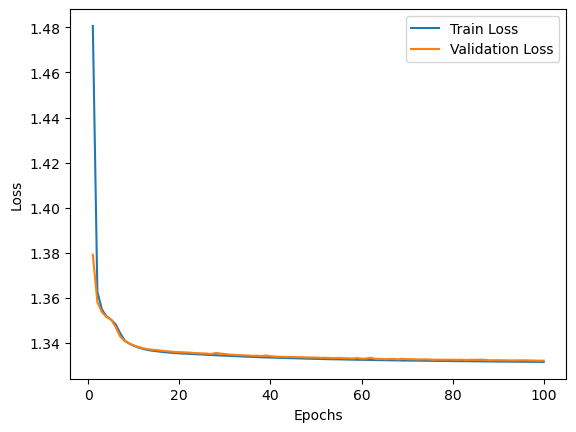

In [8]:


# Plot train and validation loss
epochs = range(1, num_epochs + 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [12]:
# Saving the model
model_path = 'C:/Users/PHB/phylo/model/model0.pth'
torch.save(model.state_dict(), model_path)
loaded_model = Autoencoder()
loaded_model.load_state_dict(torch.load(model_path))
#torch.save(model,model_path)

# Loading the model (for future use)
#loaded_model = torch.load(model_path)
loaded_model.to(device)  # Move the model to the appropriate device
loaded_model.eval()  # Set the model to evaluation mode


Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(4, 16, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 8, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(8, 16, kernel_size=(2, 1), stride=(2, 1))
    (1): ReLU()
    (2): ConvTranspose2d(16, 4, kernel_size=(2, 1), stride=(2, 1))
    (3): Sigmoid()
  )
)

In [14]:
def get_embeddings(model, data_loader):
    model.eval()
    embeddings = []
    
    with torch.no_grad():
        for data in data_loader:
            inputs = data[0].to(device)
            embedding = model(inputs, return_embeddings=True)
            embeddings.append(embedding.cpu().detach().numpy())
    
    embeddings = np.concatenate(embeddings, axis=0)
    return embeddings


In [16]:
loaded_model = Autoencoder()
loaded_model.load_state_dict(torch.load(model_path))
#torch.save(model,model_path)

# Loading the model (for future use)
#loaded_model = torch.load(model_path)
loaded_model.to(device)  # Move the model to the appropriate device
loaded_model.eval()  # Set the model to evaluation mode


Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(4, 16, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 8, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(8, 16, kernel_size=(2, 1), stride=(2, 1))
    (1): ReLU()
    (2): ConvTranspose2d(16, 4, kernel_size=(2, 1), stride=(2, 1))
    (3): Sigmoid()
  )
)

In [31]:
test_embeddings = get_embeddings(loaded_model, test_loader)

In [34]:
test_embeddings.shape

(15000, 8, 125, 1)

In [ ]:
class ComplexAutoencoder(nn.Module):
    def __init__(self):
        super(ComplexAutoencoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(4, 32, (3, 1), padding=(1, 0)),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d((2, 1), (2, 1)),
            nn.Conv2d(32, 64, (3, 1), padding=(1, 0)),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d((2, 1), (2, 1)),
            nn.Conv2d(64, 128, (3, 1), padding=(1, 0)),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d((2, 1), (2, 1)),
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, (2, 1), stride=(2, 1)),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 32, (2, 1), stride=(2, 1)),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.ConvTranspose2d(32, 4, (2, 1), stride=(2, 1)),
            nn.Sigmoid(),
        )

    def forward(self, x, return_embeddings=False):
        x = self.encoder(x)
        if return_embeddings:
            return x
        x = self.decoder(x)
        return x